## TIME SERIES WITH PYSPARK

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [1]:
#!conda install pyspark

In [1]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *

# import necesary libraries
import os
import sys

#pysparl libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

In [2]:
# load data
modelDataFile = "data/data_bank/trans.asc"

df_input = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ";") \
  .load(modelDataFile)

In [7]:
# Date transformation
df_input_date = (df_input.withColumn("orig_date", col("date").cast("string"))
                .withColumn("date", to_date(from_unixtime(unix_timestamp('orig_date', 'yyMMdd'))))
 .withColumn("date", to_date(from_unixtime(unix_timestamp('date', 'yyMMdd')))))

# Type of transaction: "PRIJEM" stands for credit and "VYDAJ" stands for withdrawal
df_trans = df_input_date.withColumn("is_expense", sf.when((col('type') == 'VYDAJ'), 1).otherwise(0))

# Select columns of interest
cols = ['trans_id', 'date','account_id','balance', 'amount','is_expense']
df_trans = df_trans.select(*cols)

#Montly partition (end of the month): because we aggregate the transactions of the month
df_trans = df_trans.withColumn('monthly_partition', create_partitions_from_df('date', "yyyy-MM-dd"))

#Sort by transaction id and date 
df_trans = df_trans.orderBy(["account_id", "date", "trans_id"], ascending = True)

## Group by Expenses & income
df_inc_exp = (df_trans.withColumn('income', sf.when(col('is_expense') == 0, col('amount')).otherwise(0))
             .withColumn('expense', sf.when(col('is_expense') == 1, col('amount')).otherwise(0)))
df_group = (df_inc_exp.groupBy("account_id", "monthly_partition")
                  .agg(sf.sum('income'), sf.sum('expense'), sf.count(sf.lit('monthly_partition')), sf.sum('is_expense'))
                  .withColumnRenamed('sum(income)', 'montly_income')
                 .withColumnRenamed('sum(expense)', 'montly_expense')
                 .withColumnRenamed('sum(is_expense)', 'n_mov_expense')
             .withColumnRenamed('count(monthly_partition)', 'n_mov_trans')
           )
## Include yar and month values
df_group = (df_group.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition'))
.withColumn('monthly_partition', col('monthly_partition').cast('string')))

## (check this function is returning duplicated data)
## Complete data by year (the function that we have only works for one year at time) -> we have data from 1993-01 to 1998-12
# we will have missing months, months without expenses and incomes 
df_complet_year = (complete_missing_months(df_group, 'monthly_partition', 'account_id', spark))
df_complet_year = df_complet_year.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).fillna(0)
#update
df_complet_year = (df_complet_year.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition')))

In [11]:
#df_complet_year.filter('''account_id = '11382' ''').sort('account_id', 'monthly_partition').show(200, False)

In [12]:
#df_group.filter('''account_id = '11382' ''').sort('account_id', 'monthly_partition').show(20, False)

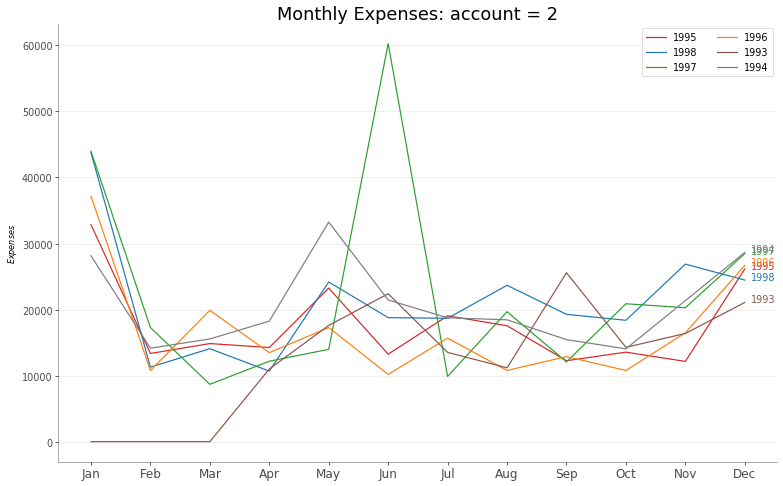

In [13]:
#transform data to pandas
id_values = '2'
df = df_complet_year.filter(col('account_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Expenses: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_expense'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

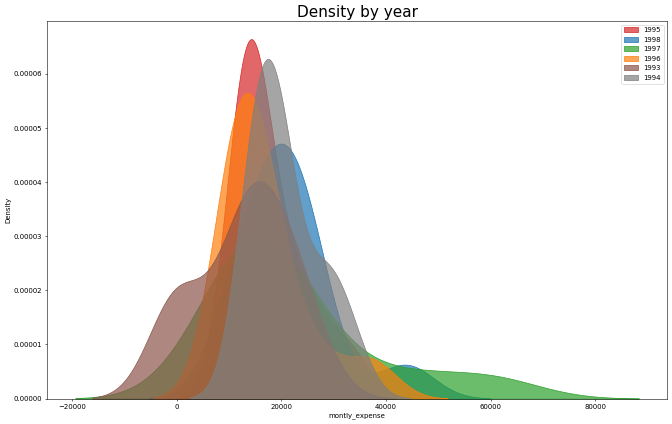

In [14]:
plot_density(df, "montly_expense", 'monthly_partition', 'Density by year')

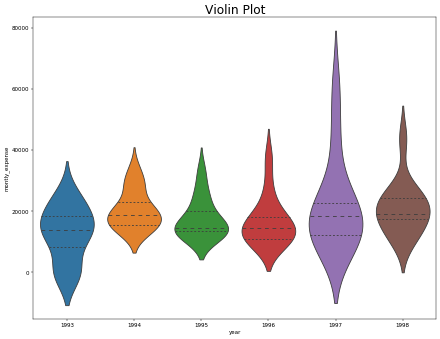

In [15]:
classes = 'year'
val =  'montly_expense'
title = 'Violin Plot'
    
plot_violin(df, classes, val, title)

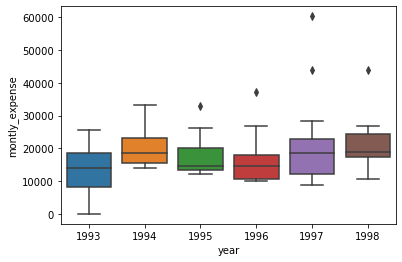

In [16]:
sns.boxplot(x=classes, y=val, data=df)

In [20]:
#check this functions is failing
#classes = 'year'
#val =  'montly_expense'
#title = 'Box Plot'
#plot_box(df, classes, val, title)

## **Outliers**

Regarding to who you are an outlier,  regarding to yourself, regarding to others in the same year. Explore the different alternatives.

In [19]:
d_outliers = find_outliers(df_group, comparison_column = 'year', filed_value = 'montly_expense').sort('year')
print('number of outliers: ', d_outliers.count())
d_outliers.show(20, False)

number of outliers:  4222
+----+----------+--------------+-----------------+------------------+----------------+-----------------+-------------------+---------+
|year|account_id|montly_expense|monthly_partition|mean              |stddev          |UpperLimit       |LowerLimit         |isOutlier|
+----+----------+--------------+-----------------+------------------+----------------+-----------------+-------------------+---------+
|1993|2242      |68200.0       |1993-06-30       |10741.296482889742|17557.5659715939|63413.99439767144|-41931.401431891965|true     |
|1993|9041      |114914.6      |1993-11-30       |10741.296482889742|17557.5659715939|63413.99439767144|-41931.401431891965|true     |
|1993|2486      |75914.6       |1993-05-31       |10741.296482889742|17557.5659715939|63413.99439767144|-41931.401431891965|true     |
|1993|4596      |69514.6       |1993-07-31       |10741.296482889742|17557.5659715939|63413.99439767144|-41931.401431891965|true     |
|1993|7753      |66714.6     

## **Change detection**

https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [23]:
df_group.show(2, False)

+----------+-----------------+------------------+-------+----+-----+
|account_id|monthly_partition|sum_amount        |n_count|year|month|
+----------+-----------------+------------------+-------+----+-----+
|6         |1995-10-01       |14783.9           |6      |1995|10   |
|6         |1996-04-01       |12277.300000000001|5      |1996|4    |
+----------+-----------------+------------------+-------+----+-----+
only showing top 2 rows



In [29]:
#just for now but we need to complete the data
df_group_2 = df_group.sort('account_id', 'monthly_partition').filter(''' account_id = '2' ''')

In [30]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
df_group_2 = df_group_2.withColumn('sum_amount_lag', lag('sum_amount').over(
            Window.partitionBy('account_id').orderBy('monthly_partition')))

In [26]:
df_group_2.sort('account_id', 'monthly_partition').show(5, False)

+----------+-----------------+----------+-------+----+-----+--------------+
|account_id|monthly_partition|sum_amount|n_count|year|month|sum_amount_lag|
+----------+-----------------+----------+-------+----+-----+--------------+
|2         |1993-02-01       |1100.0    |1      |1993|2    |null          |
|2         |1993-03-01       |23949.5   |3      |1993|3    |1100.0        |
|2         |1993-04-01       |31345.5   |3      |1993|4    |23949.5       |
|2         |1993-05-01       |37980.7   |3      |1993|5    |31345.5       |
|2         |1993-06-01       |52913.9   |3      |1993|6    |37980.7       |
+----------+-----------------+----------+-------+----+-----+--------------+
only showing top 5 rows



In [31]:
df_group_2 = df_group_2.withColumn('s_pos', col('sum_amount_lag') - col('sum_amount')).withColumn('cumsum', sf.sum('s_pos').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('s_neg', - col('sum_amount_lag') + col('sum_amount')).withColumn('cumsum', sf.sum('s_neg').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('g_neg', sf.when(col('s_neg')> 0, col('s_neg')).otherwise(0))
df_group_2 = df_group_2.withColumn('g_pos', sf.when(col('s_pos')> 0, col('s_pos')).otherwise(0))
df_group_2.show(20, False)                                                                                  

+----------+-----------------+------------------+-------+----+-----+------------------+-------------------+------------------+-------------------+------------------+------------------+
|account_id|monthly_partition|sum_amount        |n_count|year|month|sum_amount_lag    |s_pos              |cumsum            |s_neg              |g_neg             |g_pos             |
+----------+-----------------+------------------+-------+----+-----+------------------+-------------------+------------------+-------------------+------------------+------------------+
|2         |1993-02-01       |1100.0            |1      |1993|2    |null              |null               |null              |null               |0.0               |0.0               |
|2         |1993-03-01       |23949.5           |3      |1993|3    |1100.0            |-22849.5           |22849.5           |22849.5            |22849.5           |0.0               |
|2         |1993-04-01       |31345.5           |3      |1993|4    |23949.5

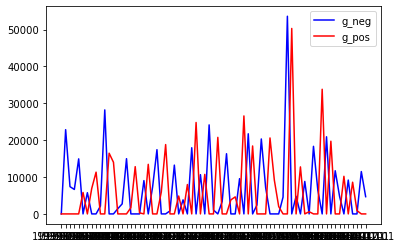

In [36]:
df_g = df_group_2.toPandas()
plt.plot(df_g['monthly_partition'], df_g['g_neg'], c = 'b', label = 'g_neg')
plt.plot(df_g['monthly_partition'], df_g['g_pos'], c = 'r', label = 'g_pos')
#plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
#plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
#plt.plot(mean_minus_std, 'k--')
#plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

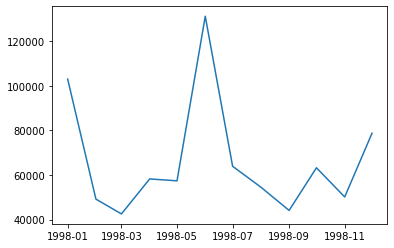

In [67]:
df_group_to_pandas = (df_group.filter('''account_id = '11382' and year= '1998' ''').sort('month')
                      .toPandas())
plt.plot(df_group_to_pandas['month'], df_group_to_pandas['sum_amount'])
plt.show()

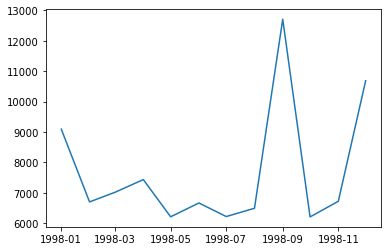

In [68]:
df_group_to_pandas = (df_group.filter('''account_id = '1' and year= '1998' ''').sort('month')
                      .toPandas())
plt.plot(df_group_to_pandas['month'], df_group_to_pandas['sum_amount'])
plt.show()

## References
- [AN ADJUSTED BOXPLOT FOR SKEWED DISTRIBUTIONS](https://wis.kuleuven.be/stat/robust/papers/2004/boxplotCOMPSTAT04.pdf)
- [Top 50 matplotlib Visualizations](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/)
- Explaining Anomalies in Groups with Characterizing Subspace Rules(https://www.andrew.cmu.edu/user/lakoglu/pubs/18-pkdd-journal-xpacs.pdf)
- anomaly-detection-resources(https://github.com/yzhao062/anomaly-detection-resources#31-multivariate-data)

In [137]:
#https://github.com/HamishWoodrow/anomaly_detection/blob/master/anom_detect.py
def plot(self,data_label=None,left=None,right=None,bottom=None,top=None):
        '''Anomalous datapoint plotting method
        This can be used to plot a visualisation of the data with the moving
        average, standard deviations and the anomalous data points marked.
        Parameters
        ----------
        data_label : str
            Raw data series name, to be displayed on y-axis and legend.
        left : int
            xlimit for left limit of plot x-axis
        right : int
            xlimit for right limit of plot x-axis
        bottom : int
            ylimit for bottom limit of plot y-axis
        top : int
            ylimit for top limit of plot y-axis
        '''
        df = self.results
        anoma_points = self.anoma_points
        fig, ax1 = plt.subplots(1, 1,figsize=(15, 8))
        ax1.plot(list(df.index),df.iloc[:,0],'b.',label=data_label)
        ax1.plot(list(df.index),df.mean_count,'r',label='Moving Average')
        ax1.fill_between(df.index,df.pos_std,df.neg_std,color='red',alpha=0.3,label='1Sigma')
        ax1.fill_between(df.index,df.pos_std_2,df.neg_std_2,color='red',alpha=0.1,label='2Sigma')
        ax1.plot(list(anoma_points.index),anoma_points.iloc[:,0],'r*',label='Anomalous Points')
        ax1.set_xlabel('time')
        ax1.set_ylabel(data_label)
        ax1.set_title('Data with Anomalies starred')
        ax1.set_xlim(left=left,right=right)
        ax1.set_ylim(bottom=bottom,top=top)
        ax1.legend();

In [ ]:
#Using Exponentially Weighted Moving Average for anomaly detection
#https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/

import pandas as pd
import matplotlib.pyplot as plt

window_size = 3
mean = work_days['Users'].ewm(window_size).mean()
std = work_days['Users'].ewm(window_size).std()
std[0] = 0 #the first value turns into NaN because of no data

mean_plus_std = mean + std
mean_minus_std = mean - std

is_outlier = (work_days['Users'] > mean_plus_std) | (work_days['Users'] < mean_minus_std)
outliers = work_days[is_outlier]

plt.plot(work_days['Users'], c = 'b', label = 'Actual Values')
plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
plt.plot(mean_minus_std, 'k--')
plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()

In [ ]:
#Weighted moving average in Pyspark
#https://stackoverflow.com/questions/47622447/weighted-moving-average-in-pyspark
from pyspark.sql.functions import coalesce, lit, col, lead, lag
from operator import add
from functools import reduce

def weighted_average(c, window, offsets, weights):
    assert len(weights) == len(offsets)

    def value(i):
        if i < 0: return lag(c, -i).over(window)
        if i > 0: return lead(c, i).over(window)
        return c

    # Create a list of Columns
    # - `value_i * weight_i` if `value_i IS NOT NULL` 
    # - literal 0 otherwise
    values = [coalesce(value(i) * w, lit(0)) for i, w in zip(offsets, weights)]

    # or sum(values, lit(0))
    return reduce(add, values, lit(0))


from pyspark.sql.window import Window

df = spark.createDataFrame([
    ("a", 1, 1.4), ("a", 2, 8.0), ("a", 3, -1.0), ("a", 4, 2.4),
    ("a", 5, 99.0), ("a", 6, 3.0), ("a", 7, -1.0), ("a", 8, 0.0)
]).toDF("id", "time", "value")

w = Window.partitionBy("id").orderBy("time")
offsets, delays =  [-2, -1, 0, 1, 2], [0.1, 0.20, 0.4, 0.20, 0.1]

result = df.withColumn("avg", weighted_average(
    col("value"), w, offsets, delays
))
result.show()


In [ ]:
#The Exponential Moving Average (EMA), the Exponential Moving Standard Deviation (EDS)
#https://machinelearnings.co/data-science-tricks-simple-anomaly-detection-for-metrics-with-a-weekly-pattern-2e236970d77#.cij9voloi
##https://stackoverflow.com/questions/33959294/apache-spark-exponential-moving-average   
    
my_window = Window.orderBy("timestamp")

df.withColumn("price_lag_1",when(lag(col("price"),1).over(my_window).isNull,lit(0)).otherwise(lag(col("price"),1).over(my_window)))

df.withColumn("ema_price", 
price * lit(0.4) * Math.pow(0.6,0) + 
lag(col("price"),1).over(my_window) * 0.4 * Math.pow(0.6,1) +
lag(col("price"),2).over(my_window) * 0.4 * Math.pow(0.6,2)  + .... )

def emaFunc (y: org.apache.spark.sql.Column, group: org.apache.spark.sql.Column, order: org.apache.spark.sql.Column, beta: Double, lookBack: Int) : org.apache.spark.sql.Column = {
  val ema_window = Window.partitionBy(group).orderBy(order)
  var i = 1
  var result = y
  while (i < lookBack){
    result =  result + lit(1) * ( when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(lag(y,i).over(ema_window)) * beta * Math.pow((1-beta),i) 
    - when(lag(y,i).over(ema_window).isNull,lit(0)).otherwise(y * beta * Math.pow((1-beta),i))   )
    i = i + 1
  }
  return result } 

df.withColumn("one",lit(1))
  .withColumn("ema_price", emaFunc('price,'one,'timestamp,0.1,10)
                                   


In [ ]:
Holt-Winter ETS
https://medium.com/@tle3006/single-seasonal-time-series-anomaly-detection-with-brutlags-algorithm-and-holt-winter-ets-d8aea1fd1bfc

https://datascience.aero/anomaly-detection/
- Change detectors based on z-scores: Z-Score measures the distance from the population mean in units of the standard error. It can be used to identify when a sample is deviating from the expected statistic of the population. One common approach is to maintain two sets of statistics (e.g. mean and std) that describe the signal and compare them using z-score.
- Cumulative sum control chart (CUSUM): It iteratively calculates the weighted cumulative sum. When this sum exceeds a certain threshold value, a change value has been found. It is a valuable “online” methodology with plenty of use in streaming change detection. There are plenty of available implementations of this algorithm.
- Bayesian detection: This method is based on the prior train of thought on how probable is it to have two successive change-points with certain distance. Then, it models the likelihood of the data in the sequence given that there is no change-point in the sequence. This methodology works well but can be slow depending on the length of the time series. There are plenty of implementations in both Python and R.
- Cost sensitive methods

- (Instance-Dependent Cost-Sensitive Learning for Detecting Transfer Fraud)[https://arxiv.org/abs/2005.02488#:~:text=Instance%2DDependent%20Cost%2DSensitive%20Learning%20for%20Detecting%20Transfer%20Fraud,-Sebastiaan%20H%C3%B6ppner%2C%20Bart&text=Fraud%20detection%20is%20to%20be,for%20learning%20a%20classification%20model.]

# Cluster Identication Using Projections

Code of the paper: 

Peña, D., & Prieto, F. J. (2011). Cluster identification using projections. Journal of the American Statistical Association.

#Link:
http://halweb.uc3m.es/esp/Personal/personas/dpena/publications/ingles/2001JASA_prieto.pdf

Mirroring from: http://halweb.uc3m.es/fjp/download.html

https://e-archivo.uc3m.es/bitstream/handle/10016/15524/cluster_prieto_JASA_2001_ps.pdf?sequence=1

In [ ]:
# proy 
https://www.dropbox.com/s/jkpg18n6xnwcie2/proy.txt?dl=0